In [7]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# Configuration
np.random.seed(42)
random.seed(42)
NUM_CUSTOMERS = 8000

def generate_churn_data(num_customers):
    fake = Faker()
    data = []

    for _ in range(num_customers):
        tenure = random.randint(30, 365*3)
        monthly_charge = round(random.uniform(20, 200), 2)

        record = {
            'customer_id': fake.uuid4(),
            'age': random.randint(18, 80),
            'gender': random.choice(['M', 'F']),
            'membership': random.choice(['Basic', 'Premium', 'Enterprise']),
            'tenure': tenure,
            'monthly_charge': monthly_charge,
            'login_frequency': random.randint(1, 30),
            'support_tickets': random.randint(0, 10),
            'payment_delays': random.randint(0, 6),
            'feature_usage': random.randint(1, 10),
            'last_login': random.randint(1, 90),
        }

        # Churn probability calculation
        churn_prob = 0.2
        churn_prob += record['payment_delays'] * 0.08
        churn_prob += (record['last_login'] > 30) * 0.3
        churn_prob -= (record['feature_usage'] > 7) * 0.12
        churn_prob = max(0.05, min(0.95, churn_prob))
        record['churned'] = int(random.random() < churn_prob)
        data.append(record)

    return pd.DataFrame(data)

churn_df = generate_churn_data(NUM_CUSTOMERS)
churn_df.to_csv('customer_data.csv', index=False)

print("Data sample:")
display(churn_df.drop('customer_id', axis=1).head())
print(f"\nChurn rate: {churn_df['churned'].mean():.2%}")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# Prepare data
X = churn_df.drop(['customer_id', 'churned'], axis=1)
y = churn_df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
numeric_features = ['age', 'monthly_charge', 'tenure', 'login_frequency',
                   'support_tickets', 'payment_delays', 'feature_usage', 'last_login']
categorical_features = ['gender', 'membership']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Build model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])

# Train model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

# Save artifacts
joblib.dump(model, 'churn_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

Data sample:


,age,gender,membership,tenure,monthly_charge,login_frequency,support_tickets,payment_delays,feature_usage,last_login,churned
0,35,M,Basic,258,24.50,5,1,5,9,12,0
1,31,M,Enterprise,95,25.36,20,0,4,4,84,1
2,55,F,Basic,889,59.68,25,2,5,7,44,1
3,39,M,Basic,470,192.30,13,1,2,6,78,1
4,52,M,Premium,118,151.35,3,8,2,10,47,0



Churn rate: 60.48%
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.46      0.52       623
           1       0.70      0.80      0.74       977

    accuracy                           0.67      1600
   macro avg       0.64      0.63      0.63      1600
weighted avg       0.66      0.67      0.65      1600


ROC AUC Score: 0.71


['preprocessor.pkl']

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       623
           1       0.71      0.71      0.71       977

    accuracy                           0.65      1600
   macro avg       0.63      0.63      0.63      1600
weighted avg       0.65      0.65      0.65      1600


Confusion Matrix:


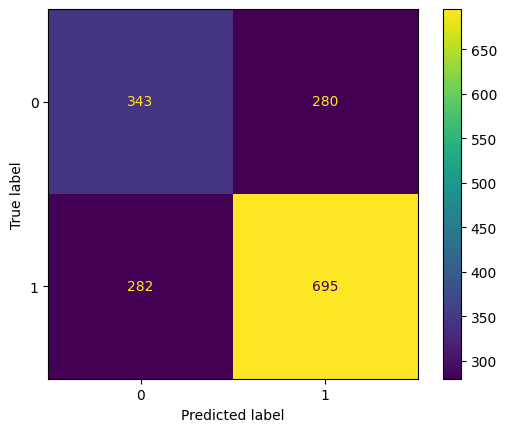

Model and preprocessor saved


In [9]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# Load data
churn_df = pd.read_csv('customer_data.csv')

# Prepare data
X = churn_df.drop(['customer_id', 'churned'], axis=1)
y = churn_df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define features
numeric_features = ['age', 'monthly_charge', 'login_frequency',
                    'support_tickets', 'payment_delays', 'feature_usage', 'last_login', 'tenure']
categorical_features = ['gender', 'membership']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Classification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Save model components
joblib.dump(model, 'churn_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Model and preprocessor saved")